In [144]:
%load_ext autoreload

%autoreload 1

In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

dbname = 'mylocaldb' 
username = 'yangyang'

con = None
con = psycopg2.connect(database = dbname, user = username)

Here is the sql query to get all the data for renter_classifier.

In [2]:
sql_query="""
SELECT u.id, u.created_at, u.sign_in_count, u.email, u.gender, u.city, u.date_of_birth,
u.last_sign_in_ip,
(u.phone is not null) as provide_phone, (u.account_type='facebook') as registered_by_fb,
w.wish_items,
r.total_orders, r.total_cost
FROM users as u
LEFT JOIN
(
SELECT user_id, COUNT(item_id) as wish_items
FROM item_wishlists
GROUP BY user_id
) as w
ON u.id=w.user_id
LEFT JOIN
(
SELECT renter_id, COUNT(total_cost) as total_orders, SUM(total_cost) as total_cost
FROM rentals
GROUP BY 
renter_id
) as r
on r.renter_id = u.id

"""
df = pd.read_sql_query(sql_query,con)
df.head(5)

,id,created_at,sign_in_count,email,gender,city,date_of_birth,last_sign_in_ip,provide_phone,registered_by_fb,wish_items,total_orders,total_cost
0,19144,2016-04-10 14:32:00.723492,4,themudpie@msn.com,female,Kingwood,1972-05-21,108.162.220.59,True,True,1.0,1.0,64.0
1,20734,2016-05-19 01:44:27.848269,13,liyaaklilu@yahoo.com,None,Ardsley,None,108.162.218.47,True,False,NaN,1.0,79.0
2,28404,2017-07-26 00:13:38.340671,14,lihu.vassar@gmail.com,female,New York,1989-05-28,162.158.255.85,True,True,NaN,1.0,59.0
3,21516,2016-07-13 13:44:42.945117,62,laniehalpern@yahoo.com,female,New York,1994-12-14,173.245.52.60,True,True,2.0,1.0,164.0
4,21313,2016-06-28 14:38:04.082623,331,amyferan@hotmail.com,None,Newark,None,162.158.62.9,True,False,31.0,5.0,249.0


# Feature engineering

Add a feature on email type.

In [9]:
def email_category(x):
    if 'msn' in x:
        return 'msn'
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'gmail' in x:
        return 'gmail'
    elif 'hotmail' in x or 'live.com' in x:
        return 'hotmail_or_live'
    elif '.edu' in x:
        return 'edu'
    elif 'comcast' in x or 'aol.com' in x or 'att.net' in x or 'verizon.net' in x:
        return 'comcast_aol_att'
    elif 'icloud' in x or 'me.com' in x or 'mac.com' in x:
        return 'icloud'
    elif 'qq' in x:
        return 'qq'
    elif 'outlook' in x:
        return 'outlook'
    else:
        return 'others'
    
df['email_type'] = df['email'].apply(email_category)

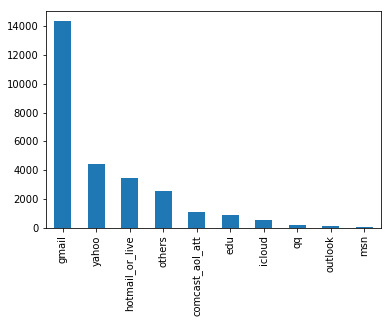

In [10]:
df['email_type'].value_counts().plot(kind='bar')

Add the city code. As the following shows, New York and San Francisco are the biggest users, 10 times larger than the third place Newark. Since 3% of the users becoming renter, we select the citis with more than 300 users.

In [11]:
a = df['city'].value_counts().sort_values(ascending=False)
a[a>200]

New York         7015
San Francisco    4333
Newark            790
Los Angeles       690
San Jose          547
Chicago           522
Dallas            470
Atlanta           386
Ashburn           366
                  312
Miami             269
London            218
Name: city, dtype: int64

Because 25% of the addresses are missing. I use the last sign in IP to approximate the address of the user. Try city vs. city_ip, which one is better?

In [12]:
import pygeoip

data_path="/Users/yangyang/Documents/Study/Insight/project/notebooks/GeoLiteCity.dat"
gi = pygeoip.GeoIP(data_path, pygeoip.MEMORY_CACHE)

country_data_path = '/Users/yangyang/Documents/Study/Insight/project/notebooks/GeoIP.dat'
gi_country = pygeoip.GeoIP(country_data_path,pygeoip.MEMORY_CACHE)


def ip_to_city(ip,gi):
    try:
        return gi.record_by_addr(ip)['city']
    except:
        return np.nan
    
def ip_to_country(ip,gi):
    try:
        return gi.country_code_by_addr(ip)
    except:
        return np.nan

df['city_by_ip'] = df['last_sign_in_ip'].apply(lambda x: ip_to_city(x, gi))
#df['country_by_ip'] = df['last_sign_in_ip'].apply(lambda x: ip_to_country(x, gi_country))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yangyang/Documents/Study/Insight/project/notebooks/GeoLiteCity.dat'

Too many miss match between city and city_by_ip.

In [35]:
df.loc[df['city_by_ip'] != df['city'],['city','city_by_ip']].head()

,city,city_by_ip
0,Kingwood,Dallas
1,Ardsley,Newark
2,New York,San Jose
3,New York,Newark
5,san francisco,San Jose


In [1]:
def city_category(x):
    try:
        if 'New York' in x:
            return 'New York'
        elif 'Francisco' in x:
            return 'San Francisco'
        elif 'Newark' in x:
            return 'Newark'
        elif 'Los Angeles' in x:
            return 'Los Angeles'
        elif 'San Jose' in x:
            return 'San Jose'
        elif 'Chicago' in x:
            return 'Chicago'
        elif 'Dallas' in x:
            return 'Dallas'
        elif 'Atlanta' in x:
            return 'Atlanta'
        elif 'Ashburn' in x:
            return 'Ashburn'
        else:
            return 'Others'
    except:
        return 'No address'

df['city_type'] = df['city'].apply(city_category)
#df['country_type'] = df['country_by_ip'].apply(lambda x: 'US' if x=='US' else 'Others')

NameError: name 'df' is not defined

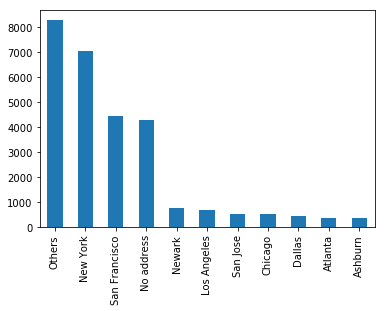

In [14]:
df['city_type'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [46]:
#df['country_type'].value_counts()

US        23738
Others     4080
Name: country_type, dtype: int64

In [15]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
df.columns

Index(['id', 'created_at', 'sign_in_count', 'email', 'gender', 'city',
       'date_of_birth', 'last_sign_in_ip', 'provide_phone', 'registered_by_fb',
       'wish_items', 'total_orders', 'total_cost', 'email_type', 'city_type'],
      dtype='object')

Create the data for train

In [33]:
df['info_items'] = (~df['date_of_birth'].isnull()).astype(int)+\
        (df['provide_phone']).astype(int)+\
        (~df['gender'].isnull()).astype(int)
        
def categorize_info(x):
    if x==0:
        return None
    elif x==1 or x==2:
        return "Partial Info"
    else:
        return "Complete Info"
df['provide_info'] = df['info_items'].apply(categorize_info)

In [64]:
from datetime import date

def calculate_age(s):
    # get the age range
    today = date.today()
    try:
        age = today.year - s.year
        if age<25:
            return "under 25"
        elif 25<=age<30:
            return "age25-30"
        elif 30<=age<35:
            return "age30-35"
        elif 35<=age<40:
            return "age35-40"
        else:
            return "40+"
    except:
        return "No_age"
    

df['age'] = df['date_of_birth'].apply( calculate_age )


In [65]:
df['wish_items'] = df['wish_items'].fillna(0)

In [69]:
# categorical features
cat_features = ['city_type','registered_by_fb', 'provide_info','age']

# continuous 
cont_features = ['wish_items','sign_in_count']

X = df[cat_features+cont_features]
X = X.fillna("None")
y = ~df['total_orders'].isnull()

# Logistic Regression using adf

- a mix of categorial and continuous features.

,city_type,registered_by_fb,provide_info,age,wish_items,sign_in_count
0,Others,True,Complete Info,40+,1.0,4
1,Others,False,Partial Info,No_age,0.0,13
2,New York,True,Complete Info,age25-30,0.0,14
3,New York,True,Complete Info,under 25,2.0,62
4,Newark,False,Partial Info,No_age,31.0,331


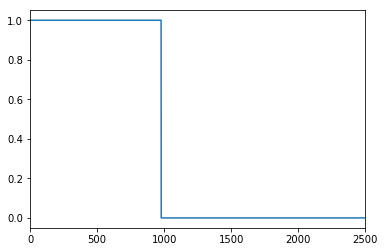

In [70]:
# downsample
X = X[0:2500]
y = y[0:2500]
y.plot()
X.head()

In [71]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
enc = OneHotEncoder(sparse = False)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

for col in X_test.columns.values:
    if X_test[col].dtypes =="object":
        data = X_train[col].append(X_test[col])
        le.fit(data.values)
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
X_age = X[~(X.age=='No_age')]
y_age = y[~(X.age=='No_age')]

In [133]:
X_dummy = pd.get_dummies(X_age,columns=cat_features)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y_age, random_state=0)


from sklearn.preprocessing import scale

from sklearn.linear_model import LogisticRegression
X_train_scale = scale(X_train)
X_test_scale = scale(X_test)

log = LogisticRegression(penalty='l2',C=1)
log.fit(X_train_scale,y_train)


from sklearn.metrics import accuracy_score

from sklearn import metrics

accuracy_score(y_test,log.predict(X_test_scale))

print(log.coef_)

fi = pd.DataFrame(log.coef_[0],index = X_test.columns.values)

fi['ab'] = abs(fi[0])

fi = fi.sort_values(['ab'],ascending=False)
fi_plot = fi[0:10]
fi_plot[0].plot(kind='barh',fontsize=20)
plt.xlabel('Feature coeffients',fontsize=20)